# Manipulate ONS LSOA Gas & Electricity Consumption Data from GB to London

Part of [london-data](https://github.com/jamesdamillington/london-data), by [jamesdamillington](https://github.com/jamesdamillington)

## Aim
Subset Lower and Middle Super Output Areas [gas consumption](https://www.gov.uk/government/statistics/lower-and-middle-super-output-areas-gas-consumption) and [electricity consumption](https://www.gov.uk/government/statistics/lower-and-middle-super-output-areas-electricity-consumption) data from Great Britain extent to London. 

Inputs are `.xlsx`, outputs will be `.csv` that can be readily joined to [ONS Geographies data](https://github.com/jamesdamillington/london-data/tree/main/data/geographies/census). 

In [1]:
from datetime import date
print(f'Last tested: {date.today()}')

Last tested: 2022-08-25


In [2]:
import pyproj
import geopandas as gpd
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt

Read [London 2011 LSOA census geography](https://github.com/jamesdamillington/london-data/tree/main/data/geographies/census) for filtering Great Britain data to London only.
> Source: Office for National Statistics licensed under the Open Government Licence v.3.0  
Contains OS data © Crown copyright and database right (2022)

In [3]:
london = gpd.read_file("../data/geographies/census/london2011-lsoa.shp")
london.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA11CD  4835 non-null   object  
 1   LSOA11NM  4835 non-null   object  
 2   MSOA11CD  4835 non-null   object  
 3   MSOA11NM  4835 non-null   object  
 4   LAD11CD   4835 non-null   object  
 5   LAD11NM   4835 non-null   object  
 6   geometry  4835 non-null   geometry
dtypes: geometry(1), object(6)
memory usage: 264.5+ KB


## Read, Clean, Filter

[Original gas data](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1050186/LSOA_domestic_gas_2010-20.xlsx) downloaded [2022-08-25].  
[Original electricity data](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1050110/LSOA_domestic_elec_2010-20.xlsx) downloaded [2022-08-25].

In [4]:
gas = "../data/inputs/energy/LSOA_domestic_gas_2010-20.xlsx"
elec = "../data/inputs/energy/LSOA_domestic_elec_2010-20.xlsx"

Function to read a sheet (per year) from the excel workbook and clean.

In [5]:
def read_clean_sheet(energy, year):
    if(energy == 'gas'):
        file = gas
    elif(energy == 'elec'):
        file = elec
    else:
        raise ValueError("energy should be 'gas' or 'elec'")

    print("reading sheet {0}...".format(year))
    thepd = pd.read_excel(io=file, sheet_name=str(year), usecols=[4,6,7,8,9], header=4)
    
    thepd.rename(inplace=True, columns={
        'LSOA code':'LSOA11CD',     #rename for merge below
        'Number\nof meters\n':'meters_n_{0}'.format(year),
        'Total \nconsumption\n(kWh)':'total_kWh_{0}'.format(year)
    })
    
    #Mean and Median column headers are formatted differently between gas and electricity!
    if(energy == 'gas'):             
        thepd.rename(inplace=True, columns={
            'Mean \nconsumption\n(kWh per meter)':'mean_kWhpm_{0}'.format(year),
            'Median \nconsumption\n(kWh per meter)':'median_kWhpm_{0}'.format(year)
        })
    if(energy == 'elec'):
        thepd.rename(inplace=True, columns={
            'Mean consumption\n(kWh per meter)':'mean_kWhpm_{0}'.format(year),
            'Median consumption\n(kWh per meter)':'median_kWhpm_{0}'.format(year)
        })
    return thepd

Read data for each sheet in gas Excel file and combine into single DataFrame for London LSOAs only

In [6]:
london_gas = london.copy(deep=False)

for yr in range(2010,2021):
    thispd = read_clean_sheet(energy='gas', year=yr)
    london_gas = pd.merge(london_gas,thispd,on=['LSOA11CD'], how='left')  #retains London LSOAs only

reading sheet 2010...
reading sheet 2011...
reading sheet 2012...
reading sheet 2013...
reading sheet 2014...
reading sheet 2015...
reading sheet 2016...
reading sheet 2017...
reading sheet 2018...
reading sheet 2019...
reading sheet 2020...


Read data for each sheet in electricity Excel file and combine into single DataFrame for London LSOAs only

In [7]:
london_elec = london.copy(deep=False)

for yr in range(2010,2021):
    thispd = read_clean_sheet(energy='elec', year=yr)
    london_elec = pd.merge(london_elec,thispd,on=['LSOA11CD'], how='left')

reading sheet 2010...
reading sheet 2011...
reading sheet 2012...
reading sheet 2013...
reading sheet 2014...
reading sheet 2015...
reading sheet 2016...
reading sheet 2017...
reading sheet 2018...
reading sheet 2019...
reading sheet 2020...


## Check 
Note there are missing values for some LSOAs. As the notes (see metadata) state:
>Where no figures are provided for a given LSOA this is because no domestic gas meters were allocated to the LSOA. The possible reasons for this are:  
>- No domestic gas meters had postcodes which could be matched to the LSOA in question. This includes LSOAs which had no domestic properties   connected to the gas grid.
>- Any domestic gas meters matched to the given LSOA were re-allocated to the "Unallocated" row for disclosure control reasons (e.g. if there were fewer    than 5 meters matched to the LSOA).

We can see likely missing 'industrial' LSOAs along the river:

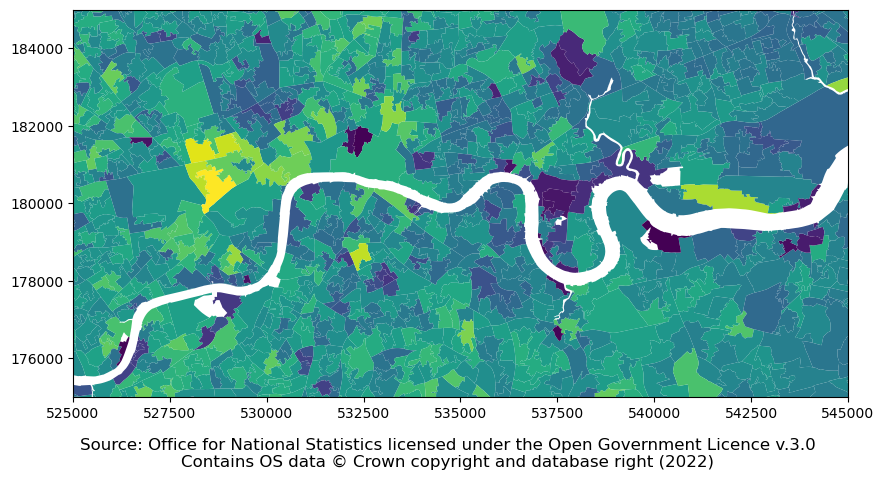

In [8]:
custom_xlim=(525000,545000)
custom_ylim=(175000,185000)
licence="Source: Office for National Statistics licensed under the Open Government Licence v.3.0\nContains OS data © Crown copyright and database right (2022)"

fig, ax = plt.subplots(1, figsize=(10, 5.5))
london_gas.plot(column='meters_n_2011',ax=ax)
plt.setp(ax, xlim=custom_xlim, ylim=custom_ylim)
fig.supxlabel(licence)
plt.show()

## Write to file 

In [9]:
#drop geometry data from output files
london_gas.drop('geometry',axis=1, inplace=True)
london_elec.drop('geometry',axis=1, inplace=True)

In [10]:
london_gas.to_csv("../data/energy/london-2010-2020-gas.csv",index=False)
london_elec.to_csv("../data/energy/london-2010-2020-elec.csv",index=False)

Create metadata files (including notes from original Excel sheet)

In [11]:
with open('../data/energy/metadata_gas.txt', 'w') as file:
    file.write('Metadata \n')
    file.write('Data are from https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1050186/LSOA_domestic_gas_2010-20.xlsx \n')
    file.write('Column names are formatted from the original Excel sheet as follows: \n')
    file.write('\tLSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM are standard ONS census Geography codes') 
    file.write('\tmeters_n_#### is Number of meters for year ####\n')
    file.write('\ttotal_kWh_#### is Total consumption (kWh) for year ####\n')
    file.write('\tmean_kWhpm_#### is Mean consumption (kWh per meter) for year ####\n')
    file.write('\tmedian_kWhpm_#### is Median consumption (kWh per meter) for year ####\n')
    file.write('\nNotes below are from original file:\n') 
    pd.read_excel(io=gas,sheet_name='Cover sheet').to_string(file, index=False)  

In [12]:
with open('../data/energy/metadata_elec.txt', 'w') as file:
    file.write('Metadata \n')
    file.write('Data are from https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1050110/LSOA_domestic_elec_2010-20.xlsx \n')
    file.write('Column names are formatted from the original Excel sheet as follows: \n')
    file.write('\tLSOA11CD, LSOA11NM, MSOA11CD, MSOA11NM, LAD11CD, LAD11NM are standard ONS census Geography codes\n') 
    file.write('\tmeters_n_#### is Number of meters for year ####\n')
    file.write('\ttotal_kWh_#### is Total consumption (kWh) for year ####\n')
    file.write('\tmean_kWhpm_#### is Mean consumption (kWh per meter) for year ####\n')
    file.write('\tmedian_kWhpm_#### is Median consumption (kWh per meter) for year ####\n')
    file.write('\nNotes below are from original file:\n') 
    pd.read_excel(io=gas,sheet_name='Cover sheet').to_string(file, index=False)